In [ ]:
pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 16.2 MB/s eta 0:00:00


# **Required Imports**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sktime.datasets import load_from_tsfile_to_dataframe
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os
import time, json, itertools, copy
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import os, gc, time, json, itertools, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit


# **Loading the dataset**

In [ ]:

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("ItalyPowerDemand_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("ItalyPowerDemand_TEST.ts")


In [ ]:
print(X_train.shape)
print(X_train.head())
print(y_train)

(67, 1)
                                               dim_0
0  0    -0.710518
1    -1.183320
2    -1.372442
3...
1  0    -0.993009
1    -1.426786
2    -1.579884
3...
2  0     1.319067
1     0.569774
2     0.195128
3...
3  0    -0.812444
1    -1.157553
2    -1.416385
3...
4  0    -0.972840
1    -1.390518
2    -1.536705
3...
['1' '1' '2' '2' '1' '1' '2' '1' '1' '2' '2' '1' '1' '2' '1' '2' '1' '1'
 '2' '1' '1' '2' '1' '1' '1' '1' '1' '2' '2' '1' '1' '2' '2' '1' '2' '2'
 '1' '2' '1' '2' '1' '1' '2' '2' '1' '2' '2' '2' '2' '1' '1' '2' '2' '2'
 '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '1' '2' '2']


# **Checking for Missing Values**

In [ ]:

print("Checking if X_train has any missing values")
print(X_train.isnull().sum())

y_train_missing_values = (y_train == '') | (y_train == None)
tot_missing = y_train_missing_values.sum()

print(f"Total missing labels in Y_train: {tot_missing}")



Checking if X_train has any missing values
dim_0    0
dtype: int64
Total missing labels in Y_train: 0


# **Plotting Bar Graph to check the distribution of class**

/tmp/ipython-input-455662733.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class", data=labels_to_df, palette="Set2")


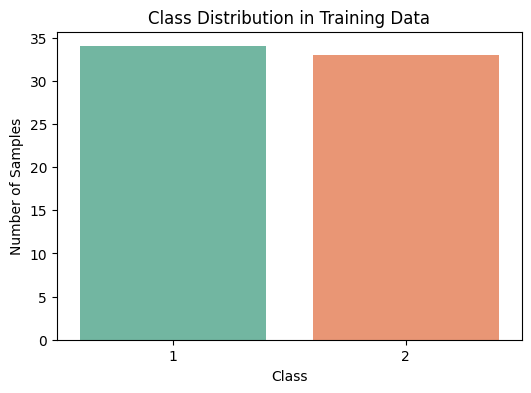

In [ ]:
# Converting labels to DataFrame
labels_to_df = pd.DataFrame(y_train, columns=["Class"])

#plotting bar graph
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=labels_to_df, palette="Set2")
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()



# **Plotting samples from each class**

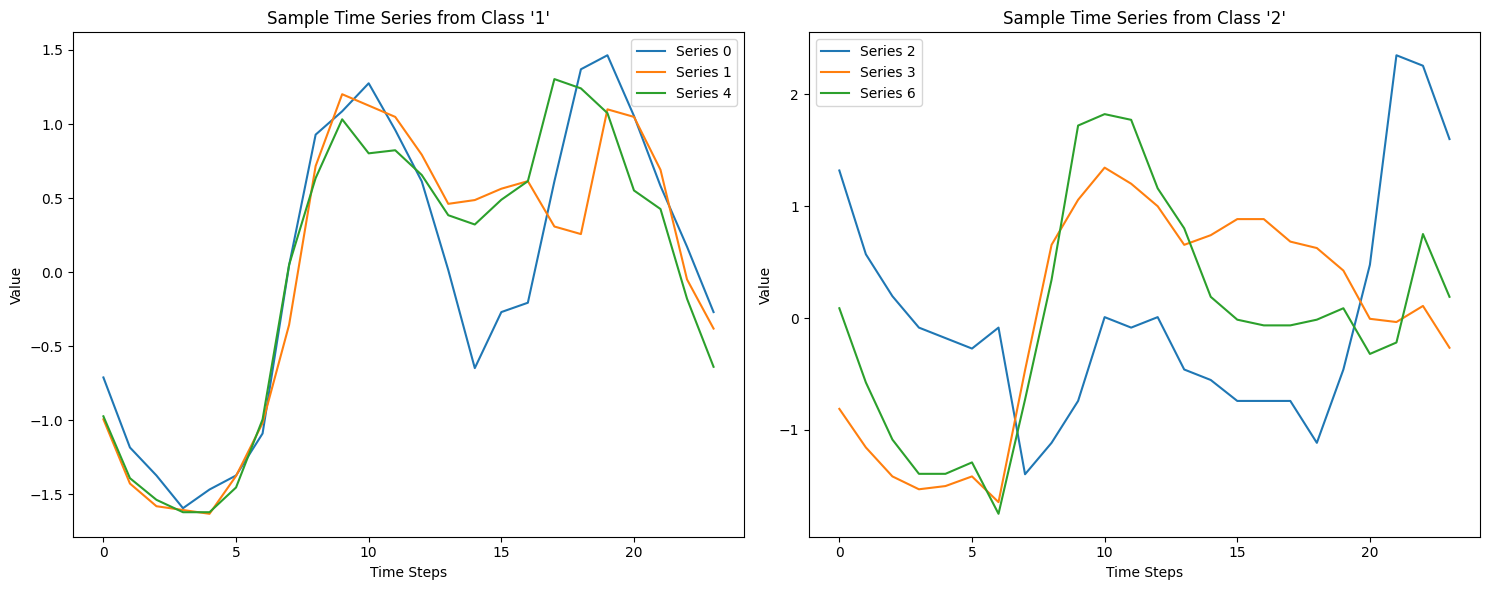

In [ ]:

# Converting series arrays to numpy array
X_train_np = np.array([ts[0] for ts in X_train.values])

# Finding indices of each class
class_1_indices = np.where(y_train == '1')[0]
class_2_indices = np.where(y_train == '2')[0]

# Plotting graphs
plt.figure(figsize=(15, 6))

# Plotting samples from Class '1'

plt.subplot(1, 2, 1)
plt.title("Sample Time Series from Class '1'")
for i in range(3):
    idx = class_1_indices[i]
    plt.plot(X_train_np[idx], label=f"Series {idx}")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value")

# Plotting samples from Class '2'
plt.subplot(1, 2, 2)
plt.title("Sample Time Series from Class '2'")
for i in range(3):
    idx = class_2_indices[i]
    plt.plot(X_train_np[idx], label=f"Series {idx}")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

In [ ]:
# Separate the time series into two arrays based on their class
X_class_1 = X_train_np[y_train == '1']
X_class_2 = X_train_np[y_train == '2']

In [ ]:
print(X_class_1)
print(X_class_2)

[[-0.71051757 -1.1833204  -1.3724416  -1.5930829  -1.4670021  -1.3724416
  -1.0887599   0.04596695  0.92853223  1.0861332   1.2752543   0.96005242
   0.61333034  0.01444676 -0.6474772  -0.26923494 -0.20619456  0.61333034
   1.3698149   1.4643754   1.054613    0.58181015  0.1720477  -0.26923494]
 [-0.99300935 -1.4267865  -1.5798843  -1.6054006  -1.6309169  -1.3757539
  -1.0185257  -0.35510183  0.71658276  1.2013925   1.1248436   1.0482947
   0.79313166  0.46141977  0.48693607  0.56348497  0.61451757  0.30832197
   0.25728936  1.0993273   1.0482947   0.69106647 -0.04890624 -0.38061813]
 [-0.97284033 -1.3905178  -1.5367049  -1.6202404  -1.6202404  -1.4531694
  -0.9937242   0.05046937  0.63521776  1.0320113   0.80228873  0.8231726
   0.65610163  0.3846113   0.32195969  0.48903066  0.61433389  1.3035016
   1.24085     1.0737791   0.55168227  0.42637904 -0.17925321 -0.63869838]
 [ 0.36742384 -0.27780827 -0.76173234 -0.86927102 -1.1381178  -1.0843484
  -1.1381178  -0.60042432 -1.0843484  -0.2

# **Plotting average time series**

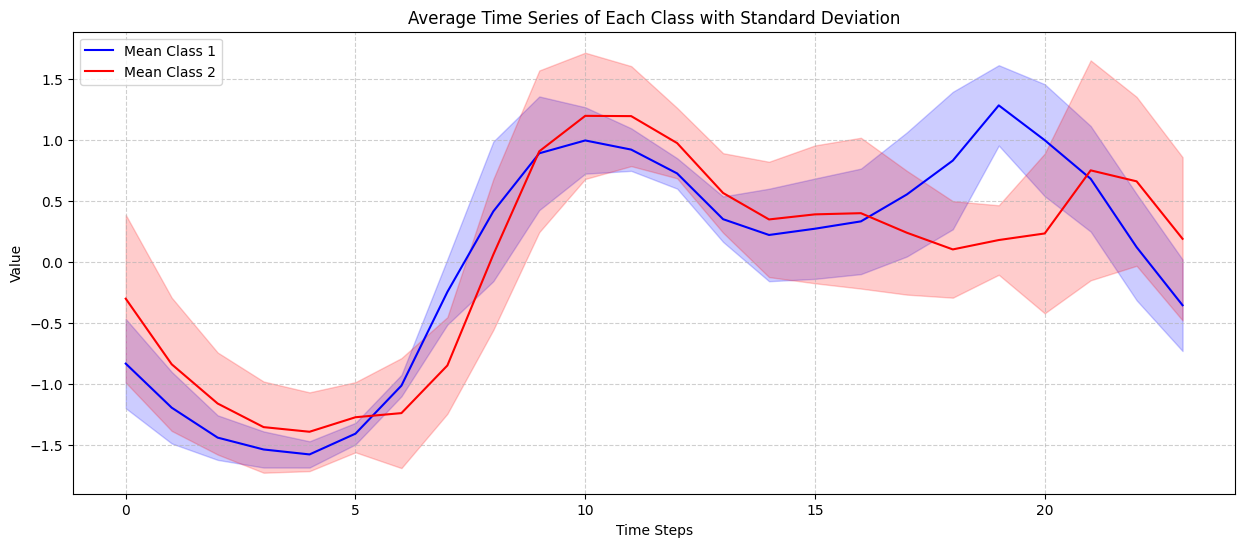

In [ ]:
plt.figure(figsize=(15, 6))

# Calculating mean and standard deviation for each class
mean_class_1 = X_class_1.mean(axis=0)
std_class_1 = X_class_1.std(axis=0)
mean_class_2 = X_class_2.mean(axis=0)
std_class_2 = X_class_2.std(axis=0)

# Plotting for Class 1
plt.plot(mean_class_1, label="Mean Class 1", color='blue')
plt.fill_between(range(len(mean_class_1)), mean_class_1 - std_class_1, mean_class_1 + std_class_1, color='blue', alpha=0.2, label='_nolegend_')

# Plotting for Class 2
plt.plot(mean_class_2, label="Mean Class 2", color='red')
plt.fill_between(range(len(mean_class_2)), mean_class_2 - std_class_2, mean_class_2 + std_class_2, color='red', alpha=0.2, label='_nolegend_')

plt.title("Average Time Series of Each Class with Standard Deviation")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **Box Plot for Each Time Step**

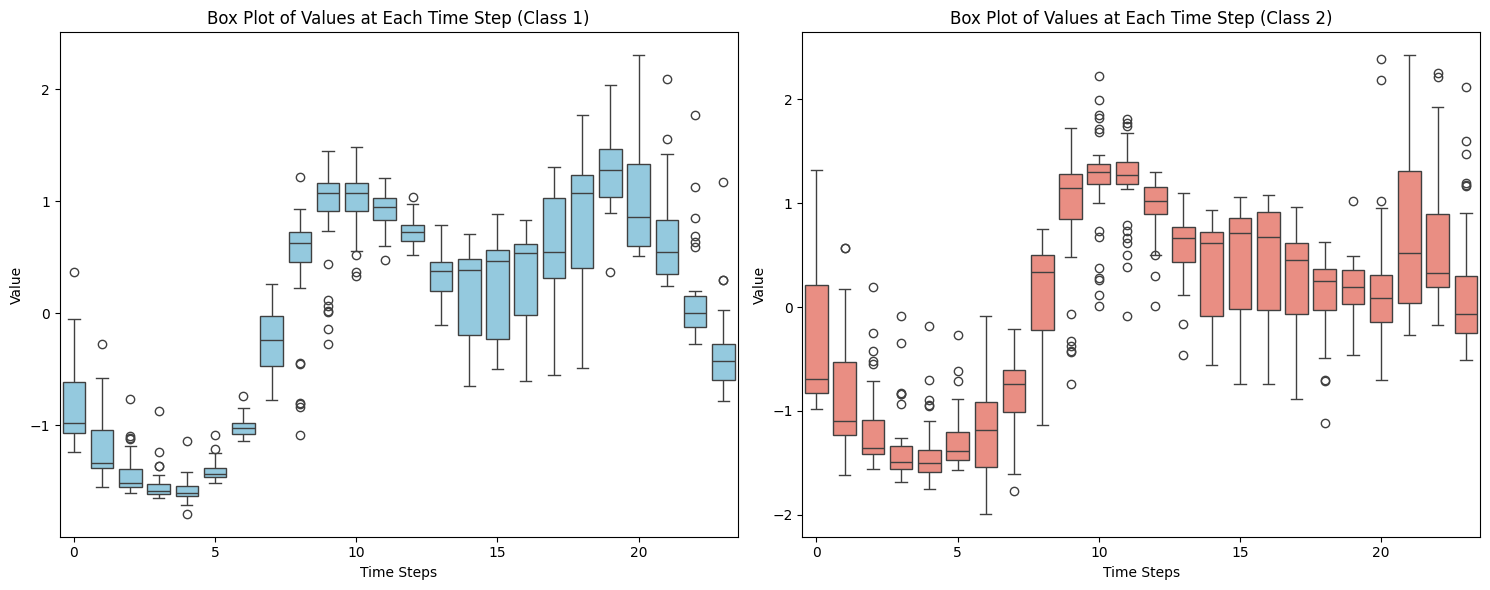

In [ ]:

plt.figure(figsize=(15, 6))

# Boxplot for Class 1
plt.subplot(1, 2, 1)
sns.boxplot(data=pd.DataFrame(X_class_1), color='skyblue')
plt.title("Box Plot of Values at Each Time Step (Class 1)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.xticks(np.arange(0, X_class_1.shape[1], 5))

# Boxplot for Class 2
plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame(X_class_2), color='salmon')
plt.title("Box Plot of Values at Each Time Step (Class 2)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.xticks(np.arange(0, X_class_2.shape[1], 5))

plt.tight_layout()
plt.show()

# **Mean Value Distribution for classes**

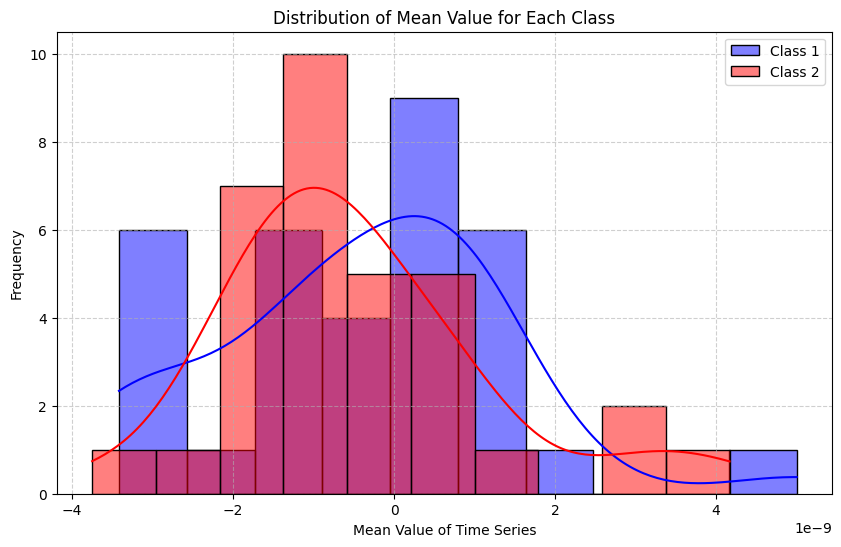

In [ ]:
plt.figure(figsize=(10, 6))

# Calculating mean of each time series
mean_values_class_1 = X_class_1.mean(axis=1)
mean_values_class_2 = X_class_2.mean(axis=1)

# Plotting the distribution of the mean values
sns.histplot(mean_values_class_1, color='blue', kde=True, label="Class 1", bins=10)
sns.histplot(mean_values_class_2, color='red', kde=True, label="Class 2", bins=10)

plt.title("Distribution of Mean Value for Each Class")
plt.xlabel("Mean Value of Time Series")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **HeatMap of All Time Series**

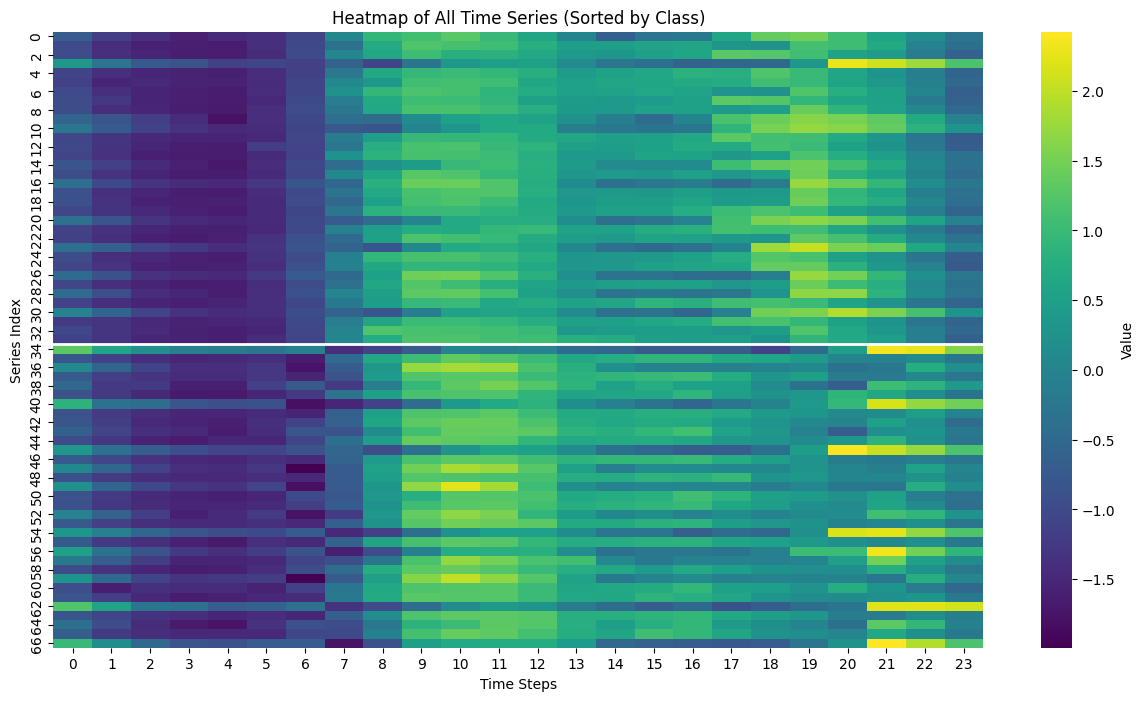

In [ ]:
plt.figure(figsize=(15, 8))

# Sorting the data by class
sorted_X = np.vstack((X_class_1, X_class_2))
sorted_y = np.hstack((np.repeat('1', len(X_class_1)), np.repeat('2', len(X_class_2))))

# Creating a heatmap of the time series values
sns.heatmap(sorted_X, cmap='viridis', cbar_kws={'label': 'Value'})

plt.title("Heatmap of All Time Series (Sorted by Class)")
plt.xlabel("Time Steps")
plt.ylabel("Series Index")

plt.axhline(y=len(X_class_1), color='white', linewidth=2)

plt.show()

# **Applying Basic Pre-processing to Dataset**

In [ ]:

# Convertting the dataframe to 3D NumPy arrays

def dataframe_to_3d_array(X):
    if isinstance(X, pd.DataFrame):
        series_list = X.iloc[:, 0].tolist()
    elif isinstance(X, np.ndarray):
        series_list = X[:, 0].tolist()
    else:
        raise TypeError("Expected DataFrame or ndarray")
    return np.array([np.array(s) for s in series_list])[..., np.newaxis]

X_train_np = dataframe_to_3d_array(X_train)
X_test_np = dataframe_to_3d_array(X_test)

# Z-score standardization (per time series)
def z_score_standardize(X):
    X_standard = np.zeros_like(X)
    for i in range(X.shape[0]):
        ts = X[i, :, 0]
        mean = np.mean(ts)
        std = np.std(ts)
        if std == 0:
            std = 1
        X_standard[i, :, 0] = (ts - mean) / std
    return X_standard

X_train_np = z_score_standardize(X_train_np)
X_test_np = z_score_standardize(X_test_np)

#Encoding class labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# **Function to plot accuracy/loss curves**

In [ ]:

def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc = h.get('accuracy', h.get('acc'))
    h_val_acc = h.get('val_accuracy', h.get('val_acc'))
    h_loss = h.get('loss')
    h_val_loss = h.get('val_loss')

    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Accuracy')
        plt.plot(h_val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss')
        plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


# **1D CNN Model**


 Run 1 — Epochs: 100, LR: 0.01, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9689 | Precision: 0.9745 | Recall: 0.9632 | F1: 0.9688

 Run 2 — Epochs: 100, LR: 0.01, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9514 | Precision: 0.9698 | Recall: 0.9322 | F1: 0.9506

 Run 3 — Epochs: 100, LR: 0.01, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9699 | Precision: 0.9727 | Recall: 0.9671 | F1: 0.9699

 Run 4 — Epochs: 100, LR: 0.001, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9611 | Precision: 0.9741 | Recall: 0.9477 | F1: 0.9607

 Run 5 — Epochs: 100, LR: 0.001, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9611 | Precision: 0.9741 | Recall: 0.9477 | F1: 0.9607

 Run 6 — Epochs: 100, LR: 0.001, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9679 | Precision: 0.9671 | Recall: 0.9690 | F1: 0.9681

 Run 7 — Epochs: 100, LR: 0.1, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.8756 | Precision: 0.9949 | Recall: 0.7558 | F1: 0.8590

 Run 8 — Epochs: 100, LR: 0.1, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9572 | Precision: 0.9701 | Recall: 0.9438 | F1: 0.9568

 Run 9 — Epochs: 100, LR: 0.1, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9339 | Precision: 0.9553 | Recall: 0.9109 | F1: 0.9325

 Run 10 — Epochs: 500, LR: 0.01, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9417 | Precision: 0.9770 | Recall: 0.9050 | F1: 0.9396

 Run 11 — Epochs: 500, LR: 0.01, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9660 | Precision: 0.9706 | Recall: 0.9612 | F1: 0.9659

 Run 12 — Epochs: 500, LR: 0.01, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9640 | Precision: 0.9669 | Recall: 0.9612 | F1: 0.9640

 Run 13 — Epochs: 500, LR: 0.001, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9602 | Precision: 0.9760 | Recall: 0.9438 | F1: 0.9596

 Run 14 — Epochs: 500, LR: 0.001, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9582 | Precision: 0.9759 | Recall: 0.9399 | F1: 0.9576

 Run 15 — Epochs: 500, LR: 0.001, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9611 | Precision: 0.9760 | Recall: 0.9457 | F1: 0.9606

 Run 16 — Epochs: 500, LR: 0.1, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9359 | Precision: 0.9518 | Recall: 0.9186 | F1: 0.9349

 Run 17 — Epochs: 500, LR: 0.1, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9436 | Precision: 0.9370 | Recall: 0.9516 | F1: 0.9442

 Run 18 — Epochs: 500, LR: 0.1, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.8465 | Precision: 0.9945 | Recall: 0.6977 | F1: 0.8200

 Run 19 — Epochs: 1000, LR: 0.01, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9602 | Precision: 0.9722 | Recall: 0.9477 | F1: 0.9598

 Run 20 — Epochs: 1000, LR: 0.01, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9650 | Precision: 0.9724 | Recall: 0.9574 | F1: 0.9648

 Run 21 — Epochs: 1000, LR: 0.01, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9631 | Precision: 0.9742 | Recall: 0.9516 | F1: 0.9627

 Run 22 — Epochs: 1000, LR: 0.001, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9699 | Precision: 0.9727 | Recall: 0.9671 | F1: 0.9699

 Run 23 — Epochs: 1000, LR: 0.001, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9679 | Precision: 0.9726 | Recall: 0.9632 | F1: 0.9679

 Run 24 — Epochs: 1000, LR: 0.001, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9650 | Precision: 0.9743 | Recall: 0.9554 | F1: 0.9648

 Run 25 — Epochs: 1000, LR: 0.1, Batch Size: 8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9310 | Precision: 0.9477 | Recall: 0.9128 | F1: 0.9299

 Run 26 — Epochs: 1000, LR: 0.1, Batch Size: 16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9193 | Precision: 0.9717 | Recall: 0.8643 | F1: 0.9149

 Run 27 — Epochs: 1000, LR: 0.1, Batch Size: 32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Test Accuracy: 0.9339 | Precision: 0.9706 | Recall: 0.8953 | F1: 0.9315

 All Run Results:
    Run  Epochs  Learning Rate  Batch Size  Test Accuracy  Precision  \
0     1     100          0.010           8       0.968902   0.974510   
1     2     100          0.010          16       0.951409   0.969758   
2     3     100          0.010          32       0.969874   0.972710   
3     4     100          0.001           8       0.961127   0.974104   
4     5     100          0.001          16       0.961127   0.974104   
5     6     100          0.001          32       0.967930   0.967118   
6     7     100          0.100           8       0.875607   0.994898   
7     8     100          0.100          16       0.957240   0.970120   
8     9     100          0.100          32       0.933916   0.955285   
9    10     500          0.010           8       0.941691   0.976987   
10   11     500          0.010          16       0.965986   0.970646   
11   12     500          0.010          32  

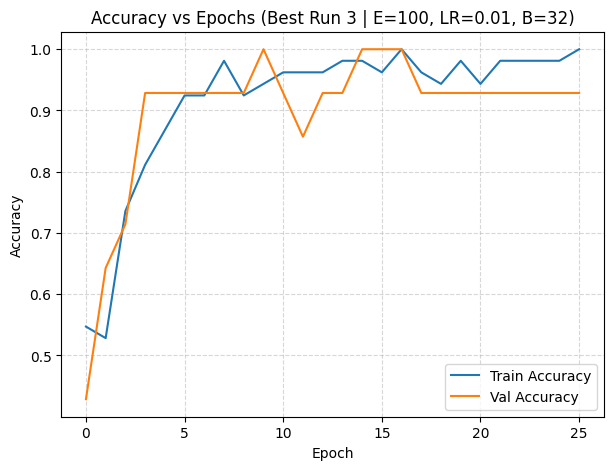

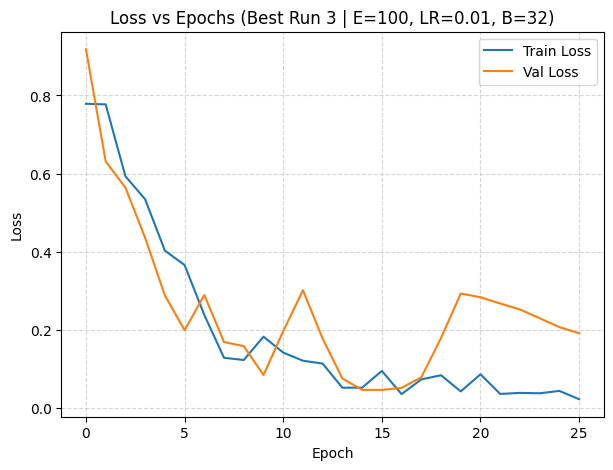

In [ ]:
# Hyperparameter combinations
epochs_list = [100, 500, 1000]
lr_list = [0.01, 0.001, 0.1]
batch_size_list = [8, 16, 32]

# Variables for Storing Results
results = []
best_cnn_acc = 0.0
best_cnn_model = None
best_cnn_model_info = {}
best_cnn_history = None
os.makedirs("saved_models", exist_ok=True)

y_train_bin = np.argmax(y_train_cat, axis=1)
y_test_bin  = np.argmax(y_test_cat, axis=1)

# Grid search
run = 0
for epochs in epochs_list:
    for lr in lr_list:
        for bs in batch_size_list:
            run += 1
            print(f"\n Run {run} — Epochs: {epochs}, LR: {lr}, Batch Size: {bs}")

            # Building 1D CNN
            model = Sequential([
                Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_np.shape[1], 1)),
                MaxPooling1D(pool_size=2),
                Dropout(0.3),
                Conv1D(128, kernel_size=3, activation='relu'),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(100, activation='relu'),
                Dropout(0.2),
                Dense(1, activation='sigmoid')
            ])

            model.compile(
                optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

            # Training the model
            history = model.fit(
                X_train_np, y_train_bin,
                epochs=epochs,
                batch_size=bs,
                verbose=0,
                validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
            )

            # Evaluating model performance
            test_loss, cnn_test_acc = model.evaluate(X_test_np, y_test_bin, verbose=0)

            y_prob = model.predict(X_test_np, verbose=0).ravel()
            y_pred = (y_prob >= 0.5).astype(int)
            y_true = y_test_bin

            cnn_precision_w = precision_score(y_true, y_pred, average='binary', zero_division=0)
            cnn_recall_w = recall_score(y_true, y_pred, average='binary', zero_division=0)
            cnn_f1_w = f1_score(y_true, y_pred, average='binary', zero_division=0)

            print(f" Test Accuracy: {cnn_test_acc:.4f} | Precision: {cnn_precision_w:.4f} | Recall: {cnn_recall_w:.4f} | F1: {cnn_f1_w:.4f}")

            # Saving results
            results.append({
                "Run": run,
                "Epochs": epochs,
                "Learning Rate": lr,
                "Batch Size": bs,
                "Test Accuracy": float(cnn_test_acc),
                "Precision": float(cnn_precision_w),
                "Recall": float(cnn_recall_w),
                "F1": float(cnn_f1_w),
            })

            # Checking if the model is best one by accuracy
            if cnn_test_acc > best_cnn_acc:
                best_cnn_acc = cnn_test_acc
                best_cnn_model = model
                best_cnn_history = history
                best_cnn_model_info = {
                    "Run": run,
                    "Epochs": epochs,
                    "Learning Rate": lr,
                    "Batch Size": bs,
                    "Test Accuracy": round(float(cnn_test_acc), 4),
                    "Precision": round(float(cnn_precision_w), 4),
                    "Recall": round(float(cnn_recall_w), 4),
                    "F1": round(float(cnn_f1_w), 4),
                }

                y_prob_cnn = best_cnn_model.predict(X_test_np, verbose=0).ravel()
                np.save("y_prob_cnn.npy", y_prob_cnn)
                np.save("y_true_bin.npy", y_test_bin.ravel())

# Final results
results_df = pd.DataFrame(results).sort_values("Run").reset_index(drop=True)
print("\n All Run Results:")
print(results_df)

print("\n Best Model Configuration:")
print(best_cnn_model_info)

summary = results_df[["Test Accuracy", "Precision", "Recall", "F1"]].agg(['mean', 'std'])
print("\n Summary across runs (Mean ± Std):")
print(summary)

# Plotting loss/accuracy curves for best run
if best_cnn_history is not None:
    plot_training_curves_inline(
        best_cnn_history,
        title_suffix=(f"(Best Run {best_cnn_model_info['Run']} | "
                      f"E={best_cnn_model_info['Epochs']}, "
                      f"LR={best_cnn_model_info['Learning Rate']}, "
                      f"B={best_cnn_model_info['Batch Size']})")
    )


# **Transformer Model**


Run 1 — Epochs: 100, LR: 0.01, Batch Size: 8
Results — Acc: 0.5015 | Precision: 0.5015 | Recall: 1.0000 | F1: 0.6680

Run 2 — Epochs: 100, LR: 0.01, Batch Size: 16
Results — Acc: 0.5015 | Precision: 0.5015 | Recall: 1.0000 | F1: 0.6680

Run 3 — Epochs: 100, LR: 0.01, Batch Size: 32
Results — Acc: 0.5015 | Precision: 0.5015 | Recall: 1.0000 | F1: 0.6680

Run 4 — Epochs: 100, LR: 0.001, Batch Size: 8
Results — Acc: 0.9679 | Precision: 0.9618 | Recall: 0.9748 | F1: 0.9682

Run 5 — Epochs: 100, LR: 0.001, Batch Size: 16
Results — Acc: 0.9718 | Precision: 0.9656 | Recall: 0.9787 | F1: 0.9721

Run 6 — Epochs: 100, LR: 0.001, Batch Size: 32
Results — Acc: 0.5015 | Precision: 0.5015 | Recall: 1.0000 | F1: 0.6680

Run 7 — Epochs: 100, LR: 0.1, Batch Size: 8
Results — Acc: 0.5015 | Precision: 0.5015 | Recall: 1.0000 | F1: 0.6680

Run 8 — Epochs: 100, LR: 0.1, Batch Size: 16
Results — Acc: 0.5015 | Precision: 0.5015 | Recall: 1.0000 | F1: 0.6680

Run 9 — Epochs: 100, LR: 0.1, Batch Size: 32
Resu

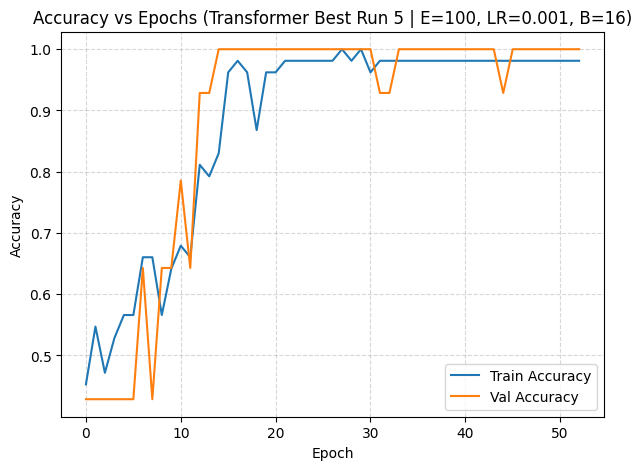

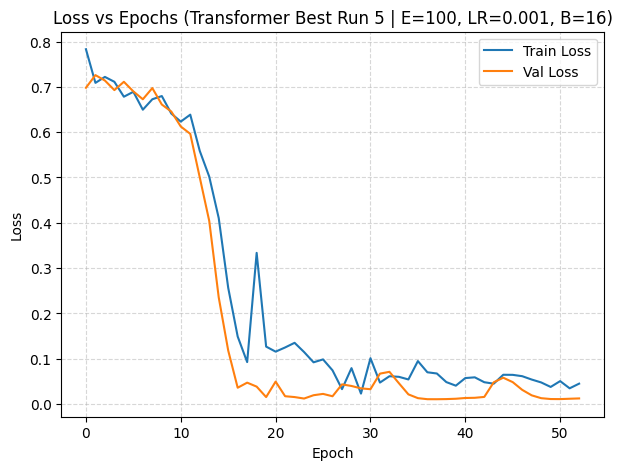

In [ ]:


# Function to plot accuracy/loss curves
def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    acc = h.get('accuracy', h.get('acc'))
    val_acc = h.get('val_accuracy', h.get('val_acc'))
    loss = h.get('loss'); val_loss = h.get('val_loss')

    if acc is not None and val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(acc, label='Train Accuracy'); plt.plot(val_acc, label='Val Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Accuracy vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()

    if loss is not None and val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(loss, label='Train Loss'); plt.plot(val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.show()


#Converting to 3d arrays
def sktime_nested_to_3d(X_nested: pd.DataFrame) -> np.ndarray:
    n_samples, n_channels = X_nested.shape
    seq_len = len(X_nested.iloc[0, 0])
    out = np.empty((n_samples, seq_len, n_channels), dtype=np.float32)
    for i in range(n_samples):
        for c in range(n_channels):
            out[i, :, c] = np.asarray(X_nested.iat[i, c], dtype=np.float32)
    return out

# Calculating per sample z-score
def z_score_per_sample(X):
    mean = X.mean(axis=1, keepdims=True)
    std  = X.std(axis=1, keepdims=True)
    std  = np.where(std == 0, 1.0, std)
    return (X - mean) / std


if 'X_train_np' not in globals() or 'X_test_np' not in globals():
    X_train_np = sktime_nested_to_3d(X_train)
    X_test_np  = sktime_nested_to_3d(X_test)
X_train_np = X_train_np.astype("float32", copy=False)
X_test_np  = X_test_np.astype("float32",  copy=False)

X_train_std = z_score_per_sample(X_train_np)
X_test_std  = z_score_per_sample(X_test_np)

seq_len, n_channels = X_train_std.shape[1], X_train_std.shape[2]

# Converting labels into binary values
le = LabelEncoder()
y_train_idx = le.fit_transform(np.asarray(y_train))
y_test_idx  = le.transform(np.asarray(y_test))
y_train_bin = y_train_idx.astype("float32").reshape(-1, 1)
y_test_bin  = y_test_idx.astype("float32").reshape(-1, 1)


#Applying sinusoidal positional encoding
class SinusoidalPositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model, **kwargs):
        super().__init__(**kwargs)
        self.maxlen = maxlen
        self.d_model = d_model

    def call(self, x):
        L = tf.shape(x)[1]
        d_model = tf.cast(self.d_model, tf.float32)

        positions = tf.cast(tf.range(L)[:, tf.newaxis], tf.float32)
        dims = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)

        angle_rates = 1.0 / tf.pow(10000.0, (2.0 * (dims // 2)) / d_model)
        angles = positions * angle_rates

        pe = tf.where(tf.equal(tf.math.floormod(tf.range(self.d_model), 2), 0),
                      tf.sin(angles), tf.cos(angles))

        return x + pe



#Building Transformer Model
def transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=128, dropout=0.1):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x); x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    y = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    y = layers.Dropout(dropout)(y); y = layers.Conv1D(filters=x.shape[-1], kernel_size=1)(y)
    y = layers.LayerNormalization(epsilon=1e-6)(y + x)
    return y



def build_ts_transformer_binary(
    seq_len, n_channels,
    d_model=64, head_size=32, num_heads=2, ff_dim=128,
    num_transformer_blocks=2, dropout=0.1,
    mlp_units=(64,), mlp_dropout=0.1,
    learning_rate=1e-3
):
    inputs = layers.Input(shape=(seq_len, n_channels))
    x = layers.Conv1D(filters=d_model, kernel_size=1, padding="same")(inputs)
    x = SinusoidalPositionalEncoding(maxlen=seq_len, d_model=d_model)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    x = layers.GlobalAveragePooling1D()(x)
    for u in (mlp_units if isinstance(mlp_units, (list, tuple)) else [mlp_units]):
        x = layers.Dense(u, activation="relu")(x); x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

ARCH = dict(
    d_model=64, head_size=32, num_heads=2, ff_dim=128,
    num_transformer_blocks=2, dropout=0.1,
    mlp_units=(64,), mlp_dropout=0.1
)

# Hyperparamter Combination
epochs_list     = [100, 500, 1000]
lr_list         = [0.01, 0.001, 0.1]
batch_size_list = [8, 16, 32]

def seed_everything(seed=42):
    import os
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.keras.utils.set_random_seed(seed)
seed_everything(42)

results = []
best_trans_acc = 0.0
best_trans_model = None
best_trans_info = {}
best_trans_history = None

run = 0
for epochs, lr, batch in itertools.product(epochs_list, lr_list, batch_size_list):
    run += 1
    print(f"\nRun {run} — Epochs: {epochs}, LR: {lr}, Batch Size: {batch}")

    keras.backend.clear_session()
    model = build_ts_transformer_binary(seq_len=seq_len, n_channels=n_channels, learning_rate=lr, **ARCH)

    es  = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=0)
    rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5, verbose=0)

    t0 = time.time()
    history = model.fit(
        X_train_std, y_train_bin,
        epochs=epochs, batch_size=batch,
        validation_split=0.2,
        callbacks=[es, rlr], verbose=0
    )
    train_time = time.time() - t0

    # Evaluate on standardized test set
    y_prob = model.predict(X_test_std, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = y_test_bin.ravel()

    trans_acc  = accuracy_score(y_true, y_pred)
    trans_prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
    trans_rec  = recall_score(y_true, y_pred, average='binary', zero_division=0)
    trans_f1   = f1_score(y_true, y_pred, average='binary', zero_division=0)

    print(f"Results — Acc: {trans_acc:.4f} | Precision: {trans_prec:.4f} | Recall: {trans_rec:.4f} | F1: {trans_f1:.4f}")


    results.append({
        "Run": run,
        "Epochs": epochs,
        "Learning Rate": lr,
        "Batch Size": batch,
        "Accuracy": float(trans_acc),
        "Precision": float(trans_prec),
        "Recall": float(trans_rec),
        "F1": float(trans_f1),
        "Train Time (s)": round(train_time, 2),
    })

    if trans_acc > best_trans_acc:
      best_trans_acc = trans_acc
      best_trans_model = model
      best_trans_history = history
      best_trans_info = {
          "Run": run, "Epochs": epochs, "Learning Rate": lr, "Batch Size": batch,
          "Accuracy": round(float(trans_acc), 4),
          "Precision": round(float(trans_prec), 4),
          "Recall": round(float(trans_rec), 4),
          "F1": round(float(trans_f1), 4),
      }
      y_prob_trans = best_trans_model.predict(X_test_std, verbose=0).ravel()
      np.save("y_prob_trans.npy", y_prob_trans)


# --- Results table ---
results_df = pd.DataFrame(results).sort_values("Run").reset_index(drop=True)
print("\nAll Run Results:")
print(results_df)

print("\nBest Model (Transformer) Configuration:")
print(best_trans_info)

# --- Summary (mean ± std) across runs ---
summary = results_df[["Accuracy", "Precision", "Recall", "F1"]].agg(['mean', 'std'])
print("\nSummary across runs (Mean ± Std):")
print(summary)
for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    m = summary.loc["mean", metric]; s = summary.loc["std", metric]
    print(f"{metric}: {m:.4f} ± {s:.4f}")

# --- Plot curves only for BEST run ---
if best_trans_history is not None:
    plot_training_curves_inline(
        best_trans_history,
        title_suffix=(f"(Transformer Best Run {best_trans_info['Run']} | "
                      f"E={best_trans_info['Epochs']}, LR={best_trans_info['Learning Rate']}, "
                      f"B={best_trans_info['Batch Size']})")
    )


In [ ]:
# Remove large models and release GPU memory
del best_cnn_model, best_trans_model
import gc, tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()


# **Inception Time Model**


Run 1 — Epochs: 100, LR: 0.1, Batch Size: 8
Results — Acc: 0.9592 | Prec: 0.9438 | Rec: 0.9767 | F1: 0.9600

Run 2 — Epochs: 100, LR: 0.1, Batch Size: 16
Results — Acc: 0.9067 | Prec: 0.8710 | Rec: 0.9554 | F1: 0.9113

Run 3 — Epochs: 100, LR: 0.1, Batch Size: 32
Results — Acc: 0.9359 | Prec: 0.9136 | Rec: 0.9632 | F1: 0.9377

Run 4 — Epochs: 100, LR: 0.001, Batch Size: 8
Results — Acc: 0.9514 | Prec: 0.9755 | Rec: 0.9264 | F1: 0.9503

Run 5 — Epochs: 100, LR: 0.001, Batch Size: 16
Results — Acc: 0.9660 | Prec: 0.9634 | Rec: 0.9690 | F1: 0.9662

Run 6 — Epochs: 100, LR: 0.001, Batch Size: 32
Results — Acc: 0.7347 | Prec: 0.6540 | Rec: 1.0000 | F1: 0.7908

Run 7 — Epochs: 100, LR: 0.001, Batch Size: 8
Results — Acc: 0.5219 | Prec: 1.0000 | Rec: 0.0465 | F1: 0.0889

Run 8 — Epochs: 100, LR: 0.001, Batch Size: 16
Results — Acc: 0.6521 | Prec: 1.0000 | Rec: 0.3062 | F1: 0.4688

Run 9 — Epochs: 100, LR: 0.001, Batch Size: 32
Results — Acc: 0.9427 | Prec: 0.9162 | Rec: 0.9748 | F1: 0.9446



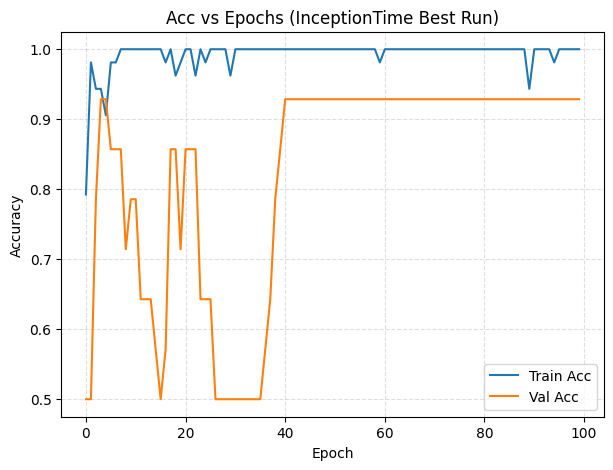

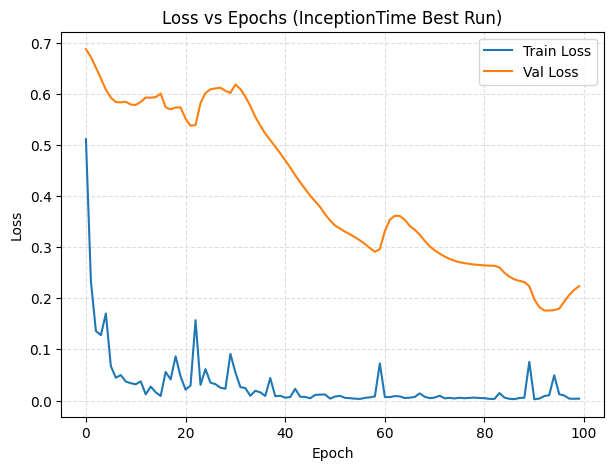

In [ ]:


# Function to plot accuracy/loss curves
def plot_training_curves_inline(history, title_suffix=""):
    h = history.history
    h_acc, h_val_acc = h.get('accuracy'), h.get('val_accuracy')
    h_loss, h_val_loss = h.get('loss'), h.get('val_loss')
    import matplotlib.pyplot as plt
    if h_acc is not None and h_val_acc is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_acc, label='Train Acc'); plt.plot(h_val_acc, label='Val Acc')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'Acc vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, ls='--', alpha=0.4); plt.show()
    if h_loss is not None and h_val_loss is not None:
        plt.figure(figsize=(7,5))
        plt.plot(h_loss, label='Train Loss'); plt.plot(h_val_loss, label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Loss vs Epochs {title_suffix}')
        plt.legend(); plt.grid(True, ls='--', alpha=0.4); plt.show()

# Applying seed to produce reproducability
SEED = 42
tf.keras.utils.set_random_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


#Pre-processing functions
def sktime_nested_to_3d(X_nested: pd.DataFrame) -> np.ndarray:
    num_samples, n_channels = X_nested.shape
    L = len(X_nested.iloc[0, 0])
    out = np.empty((num_samples, L, n_channels), dtype=np.float32)
    for i in range(num_samples):
        for c in range(n_channels):
            out[i, :, c] = np.asarray(X_nested.iat[i, c], dtype=np.float32)
    return out

def z_score_per_sample(X):
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True); s = np.where(s == 0, 1.0, s)
    return (X - m) / s

if 'X_train_std' not in globals() or 'X_test_std' not in globals():
    X_train_np = sktime_nested_to_3d(X_train)
    X_test_np  = sktime_nested_to_3d(X_test)
    X_train_std = z_score_per_sample(X_train_np)
    X_test_std  = z_score_per_sample(X_test_np)
    del X_train_np, X_test_np; gc.collect()

seq_len, n_channels = X_train_std.shape[1:]

if 'y_train_bin' not in globals() or 'y_test_bin' not in globals():
    le = LabelEncoder()
    y_train_idx = le.fit_transform(np.asarray(y_train))
    y_test_idx  = le.transform(np.asarray(y_test))
    y_train_bin = y_train_idx.astype("float32").reshape(-1, 1)
    y_test_bin  = y_test_idx.astype("float32").reshape(-1, 1)

# Applying stratified split
stratsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
(train_idx, val_idx), = stratsplit.split(X_train_std, y_train_bin.ravel())
X_tr, y_tr = X_train_std[train_idx], y_train_bin[train_idx]
X_val, y_val = X_train_std[val_idx], y_train_bin[val_idx]

def make_ds(X, y, batch, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(X), 8192), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# InceptionTime Model
def inception_module(x, nb_filters=16, kernel_size=40, bottleneck_size=32):
    if bottleneck_size > 0:
        xi = layers.Conv1D(bottleneck_size, 1, padding='same', use_bias=False)(x)
        xi = layers.BatchNormalization()(xi); xi = layers.Activation('relu')(xi)
    else:
        xi = x
    k1 = max(3, min(kernel_size, seq_len))
    k2 = max(3, min(kernel_size // 2, seq_len))
    k3 = max(3, min(kernel_size // 4, seq_len))
    c1 = layers.Conv1D(nb_filters, k1, padding='same', use_bias=False)(xi)
    c1 = layers.BatchNormalization()(c1); c1 = layers.Activation('relu')(c1)
    c2 = layers.Conv1D(nb_filters, k2, padding='same', use_bias=False)(xi)
    c2 = layers.BatchNormalization()(c2); c2 = layers.Activation('relu')(c2)
    c3 = layers.Conv1D(nb_filters, k3, padding='same', use_bias=False)(xi)
    c3 = layers.BatchNormalization()(c3); c3 = layers.Activation('relu')(c3)
    p = layers.MaxPool1D(pool_size=3, strides=1, padding='same')(xi)
    p = layers.Conv1D(nb_filters, 1, padding='same', use_bias=False)(p)
    p = layers.BatchNormalization()(p); p = layers.Activation('relu')(p)
    return layers.Concatenate(axis=2)([c1, c2, c3, p])

def shortcut_layer(x, y):
    sc = layers.Conv1D(int(y.shape[-1]), 1, padding='same', use_bias=False)(x)
    sc = layers.BatchNormalization()(sc)
    return layers.Activation('relu')(layers.Add()([sc, y]))

def build_inceptiontime_binary(seq_len, n_channels,
                               depth=3, nb_filters=16, bottleneck_size=32, kernel_size=40):
    inp = layers.Input(shape=(seq_len, n_channels))
    x = inp
    for d in range(depth):
        y = inception_module(x, nb_filters, kernel_size, bottleneck_size)
        x = shortcut_layer(x, y) if d % 3 == 2 else y
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inp, out)


IT_ARCH = dict(depth=3, nb_filters=16, bottleneck_size=32, kernel_size=40)

#Hyperparameter Combinations
epochs_list     = [100, 500, 1000]
lr_list         = [0.1, 0.001, 0.001]
batch_size_list = [8, 16, 32]


#Result Variables
results = []
best_it_acc = -1
best_it_info = {}
best_it_history = None
best_it_test_probs = None
best_it_test_true = y_test_bin.ravel()

#Applying Grid Search
run = 0
for epochs, lr, bs in itertools.product(epochs_list, lr_list, batch_size_list):
    run += 1
    print(f"\nRun {run} — Epochs: {epochs}, LR: {lr}, Batch Size: {bs}")
    keras.backend.clear_session()
    model = build_inceptiontime_binary(seq_len, n_channels, **IT_ARCH)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    train_ds = make_ds(X_tr, y_tr, bs, shuffle=True)
    val_ds   = make_ds(X_val, y_val, bs, shuffle=False)

    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=0)
    rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5, verbose=0)

    t0 = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[es, rlr], verbose=0)
    train_time = time.time() - t0

    test_ds = tf.data.Dataset.from_tensor_slices(X_test_std).batch(bs)

    y_prob = model.predict(test_ds, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = y_test_bin.ravel()

    #Calculating metrics
    incep_acc = accuracy_score(y_true, y_pred)
    incep_prec = precision_score(y_true, y_pred, zero_division=0)
    incep_rec = recall_score(y_true, y_pred, zero_division=0)
    incep_f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Results — Acc: {incep_acc:.4f} | Prec: {incep_prec:.4f} | Rec: {incep_rec:.4f} | F1: {incep_f1:.4f}")
    results.append({
        "Run": run, "Epochs": epochs, "Learning Rate": lr, "Batch Size": bs,
        "Accuracy": incep_acc, "Precision": incep_prec, "Recall": incep_rec, "F1": incep_f1
    })

    #Finding best model
    if incep_acc > best_it_acc:
        best_it_acc = incep_acc
        best_it_info = {
            "Run": run, "Epochs": epochs, "Learning Rate": lr, "Batch Size": bs,
            "Accuracy": round(incep_acc, 4), "Precision": round(incep_prec, 4),
            "Recall": round(incep_rec, 4), "F1": round(incep_f1, 4), "Architecture": IT_ARCH
        }
        best_it_history = history
        best_it_test_probs = y_prob.copy()


# Saving test probabilities from best InceptionTime model
np.save("y_prob_incep.npy", best_it_test_probs)
print("Saved: y_prob_incep.npy")

# Results dataframe
df = pd.DataFrame(results)
print("\nAll Runs:")
print(df)

print("\nBest Run:")
print(best_it_info)

# Saving best config
os.makedirs("saved_models", exist_ok=True)
with open("saved_models/best_inceptiontime_config.json", "w") as f:
    json.dump(best_it_info, f, indent=2)

# Calling function to plot training curves for best run
plot_training_curves_inline(best_it_history, title_suffix="(InceptionTime Best Run)")

# Cleanup
del best_it_test_probs, best_it_history
gc.collect()
keras.backend.clear_session()

# **Plotting Overlay PR Curve**

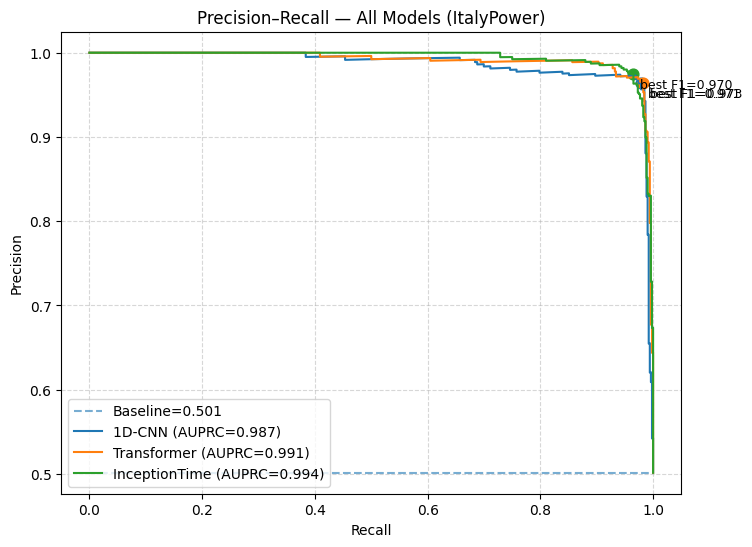

1D-CNN: AUPRC=0.9868 | best F1=0.9712 @ thr=0.170
Transformer: AUPRC=0.9913 | best F1=0.9731 @ thr=0.215
InceptionTime: AUPRC=0.9937 | best F1=0.9698 @ thr=0.639


{'1D-CNN': {'aps': 0.986787104746351,
  'best_f1': 0.9711538461533462,
  'best_threshold': 0.1701871007680893},
 'Transformer': {'aps': 0.9913173024825647,
  'best_f1': 0.9731285988478685,
  'best_threshold': 0.2147800773382187},
 'InceptionTime': {'aps': 0.9937402599871673,
  'best_f1': 0.9698149951309507,
  'best_threshold': 0.6391733288764954}}

In [ ]:
# Loading saved predictions
y_true_bin   = np.load("y_true_bin.npy")
y_prob_cnn   = np.load("y_prob_cnn.npy")
y_prob_trans = np.load("y_prob_trans.npy")
y_prob_incep = np.load("y_prob_incep.npy")


#Function to plot overlay PR curve
def plot_pr_overlay_binary(
    y_true_pos,
    scores_dict,
    title="PR — ItalyPower (Binary) — Best Models",
    loc="lower left",
    show_baseline=True,
    mark_best_f1=True
):
   #Pre-processing the labels
    y_true_pos = np.asarray(y_true_pos).astype(int).ravel()

    plt.figure(figsize=(8, 6))
    out = {}

    if show_baseline:
        base = y_true_pos.mean()
        plt.hlines(base, 0, 1, linestyles="--", alpha=0.6, label=f"Baseline={base:.3f}")

    #Looping through models
    for model_name, scores in scores_dict.items():
        scores = np.asarray(scores).ravel()
        prec, rec, th = precision_recall_curve(y_true_pos, scores)
        aps = average_precision_score(y_true_pos, scores)
        plt.plot(rec, prec, label=f"{model_name} (AUPRC={aps:.3f})")

        best_f1 = None
        best_thr = None
        if mark_best_f1 and th.size > 0:
            # thresholds align with precision[:-1], recall[:-1]
            f1s = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
            best_idx = int(np.nanargmax(f1s))
            best_f1 = float(f1s[best_idx])
            best_thr = float(th[best_idx])
            plt.scatter(rec[:-1][best_idx], prec[:-1][best_idx], s=60)
            plt.annotate(f"best F1={best_f1:.3f}", (rec[:-1][best_idx], prec[:-1][best_idx]),
                         xytext=(5, -10), textcoords="offset points", fontsize=9)

        out[model_name] = {"aps": float(aps)}
        if best_f1 is not None:
            out[model_name].update({"best_f1": best_f1, "best_threshold": best_thr})

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc=loc)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Print a tidy summary
    for name, metrics in out.items():
        if "best_f1" in metrics:
            print(f"{name}: AUPRC={metrics['aps']:.4f} | best F1={metrics['best_f1']:.4f} @ thr={metrics['best_threshold']:.3f}")
        else:
            print(f"{name}: AUPRC={metrics['aps']:.4f}")
    return out

# PR curve
plot_pr_overlay_binary(
    y_true_pos=y_true_bin,
    scores_dict={
        "1D-CNN": y_prob_cnn,
        "Transformer": y_prob_trans,
        "InceptionTime": y_prob_incep
    },
    title="Precision–Recall — All Models (ItalyPower)"
)
